# Evolutionary Algorithms for Combinatorial Multi-Knapsack
## EA Functions
### Imports and Config

In [15]:
import time, array, random, copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from deap import algorithms, base, benchmarks, tools, creator
import seaborn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### Instance Creation

In [16]:


def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst
def instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate):
    with open(file_name) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0].strip()
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d


### Population Generation, Fitness, Mutation, and Xover

In [17]:
def eval_fitness(individual, instance):
    n_kp = instance.get("n_kp")
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*n_kp
    knapsacks_profit = [0]*n_kp
    
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] <= n_kp:
            knapsack = individual[i] - 1
            knapsacks_weight[knapsack] += weights[i]
            knapsacks_profit[knapsack] += profits[i]
            for j in range(len(individual)):
                if knapsack == individual[j] - 1:
                    knapsacks_profit[knapsack] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    f3 = min(knapsacks_profit)

    for i in range(n_kp):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    return f1, f2, f3

def uniform(low, m, n_kp):
    n = [0]*m
    for i in range(0,m):
        n[i] = random.randint(0,n_kp)
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x, n_kp):
    index = random.randrange(len(x))
    var = random.randint(0,n_kp)
    x[index] = var
    return x,


### Running EA

In [18]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

### Single Execution Script

In [19]:
def execute_EA(instance):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0, 1.0))
    creator.create("Individual", list, typecode='i', 
                   fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    num_kp = instance.get("n_kp")
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", favorite_child_xover)
    toolbox.register("mutate", lambda x: mutation(x, num_kp),)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = instance.get("pop_size")
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    res,logbook = run_ea(toolbox)

    fronts = tools.emo.sortLogNondominated(res, len(res))
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    
    st_front = []
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df = df.rename(columns={0: "f1", 1: "f2", 2: "f3"})
        ax1.scatter3D(df.f1, df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax2.scatter(df.f1, df.f2, label='Front'+str(i+1), color=plot_colors[i])
        ax3.scatter(df.f1, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax4.scatter(df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        st_front.append(df)
    ax1.legend();ax2.legend();ax3.legend();ax4.legend()
    ax1.set_xlabel('$f_1(\mathbf{x})$');ax1.set_ylabel('$f_2(\mathbf{x})$');ax1.set_zlabel('$f_3(\mathbf{x})$')
    ax2.set_xlabel('$f_1(\mathbf{x})$');ax2.set_ylabel('$f_2(\mathbf{x})$')
    ax3.set_xlabel('$f_1(\mathbf{x})$');ax3.set_ylabel('$f_3(\mathbf{x})$')
    ax4.set_xlabel('$f_2(\mathbf{x})$');ax4.set_ylabel('$f_3(\mathbf{x})$')
    stats = []
    for i in range(len(st_front)):
        stat_dict = {'front': i+1,
                     'instance_name': instance.get('ref'),
                     'xover_rate': instance.get('xover_rate'),
                     'mut_rate': instance.get('mut_rate'),
                     'pop_size': instance.get('pop_size'),
                     'num_gen': instance.get('num_gen'),
                     'n_kp': instance.get('n_kp'),
                     'mean_f1' : np.mean(st_front[i].f1),
                     'median_f1' : np.median(st_front[i].f1),
                     'variance_f1': np.var(st_front[i].f1), 
                     'sample_size': len(st_front[i].f1), 
                     'min_f1': min(st_front[i].f1),
                     'max_f1': max(st_front[i].f1),
                     'mean_f2' : np.mean(st_front[i].f2),
                     'median_f2' : np.median(st_front[i].f2),
                     'variance_f2': np.var(st_front[i].f2),
                     'sample_size': len(st_front[i].f2),
                     'min_f2': min(st_front[i].f2),
                     'max_f2': max(st_front[i].f2),
                     'mean_f3' : np.mean(st_front[i].f3),
                     'median_f3' : np.median(st_front[i].f3),
                     'variance_f3': np.var(st_front[i].f3),
                     'sample_size': len(st_front[i].f3),
                     'min_f3': min(st_front[i].f3),
                     'max_f3': max(st_front[i].f3)}
        stats.append(stat_dict)
    stats_df = pd.DataFrame(stats)
    return res,logbook, fronts, stats_df

### Multiple Instance Testing Function

In [7]:
### TODO: Make this function

## Running and Testing
### Single Execution

gen	nevals	max    	avg    
0  	100   	16305.4	6248.31
1  	82    	17867.1	6670.77
2  	86    	17867.1	6705.52
3  	85    	17867.1	6759.27
4  	82    	17867.1	6786.6 
5  	82    	17867.1	6820.99
6  	80    	17976.4	6531.33
7  	88    	17976.4	7244.55
8  	82    	17976.4	7378.55
9  	91    	18255.5	7083.54
10 	93    	18759.4	7375.7 
11 	91    	18759.4	7519.59
12 	85    	18972.3	7545.64
13 	86    	18972.3	7476.19
14 	88    	18972.3	7356.52
15 	83    	18972.3	7394.57
16 	85    	18972.3	7415.42
17 	88    	18997.5	7526.66
18 	89    	19914.6	7509.27
19 	85    	19914.6	7580.41
20 	86    	19914.6	7462.16
21 	86    	19914.6	7332.95
22 	89    	19914.6	7532.59
23 	89    	19914.6	7450.51
24 	79    	19914.6	7857.2 
25 	84    	20391.4	7666.26
26 	83    	20594.1	7755.22
27 	86    	21307.4	7544.56
28 	88    	21307.4	7418.86
29 	85    	21307.4	7768.56
30 	77    	21307.4	7714.79
31 	86    	21307.4	7930.81
32 	85    	21522  	7945.96
33 	88    	21943.2	8140.02
34 	91    	21943.2	8334.65
35 	86    	21943.2	8291.17
3

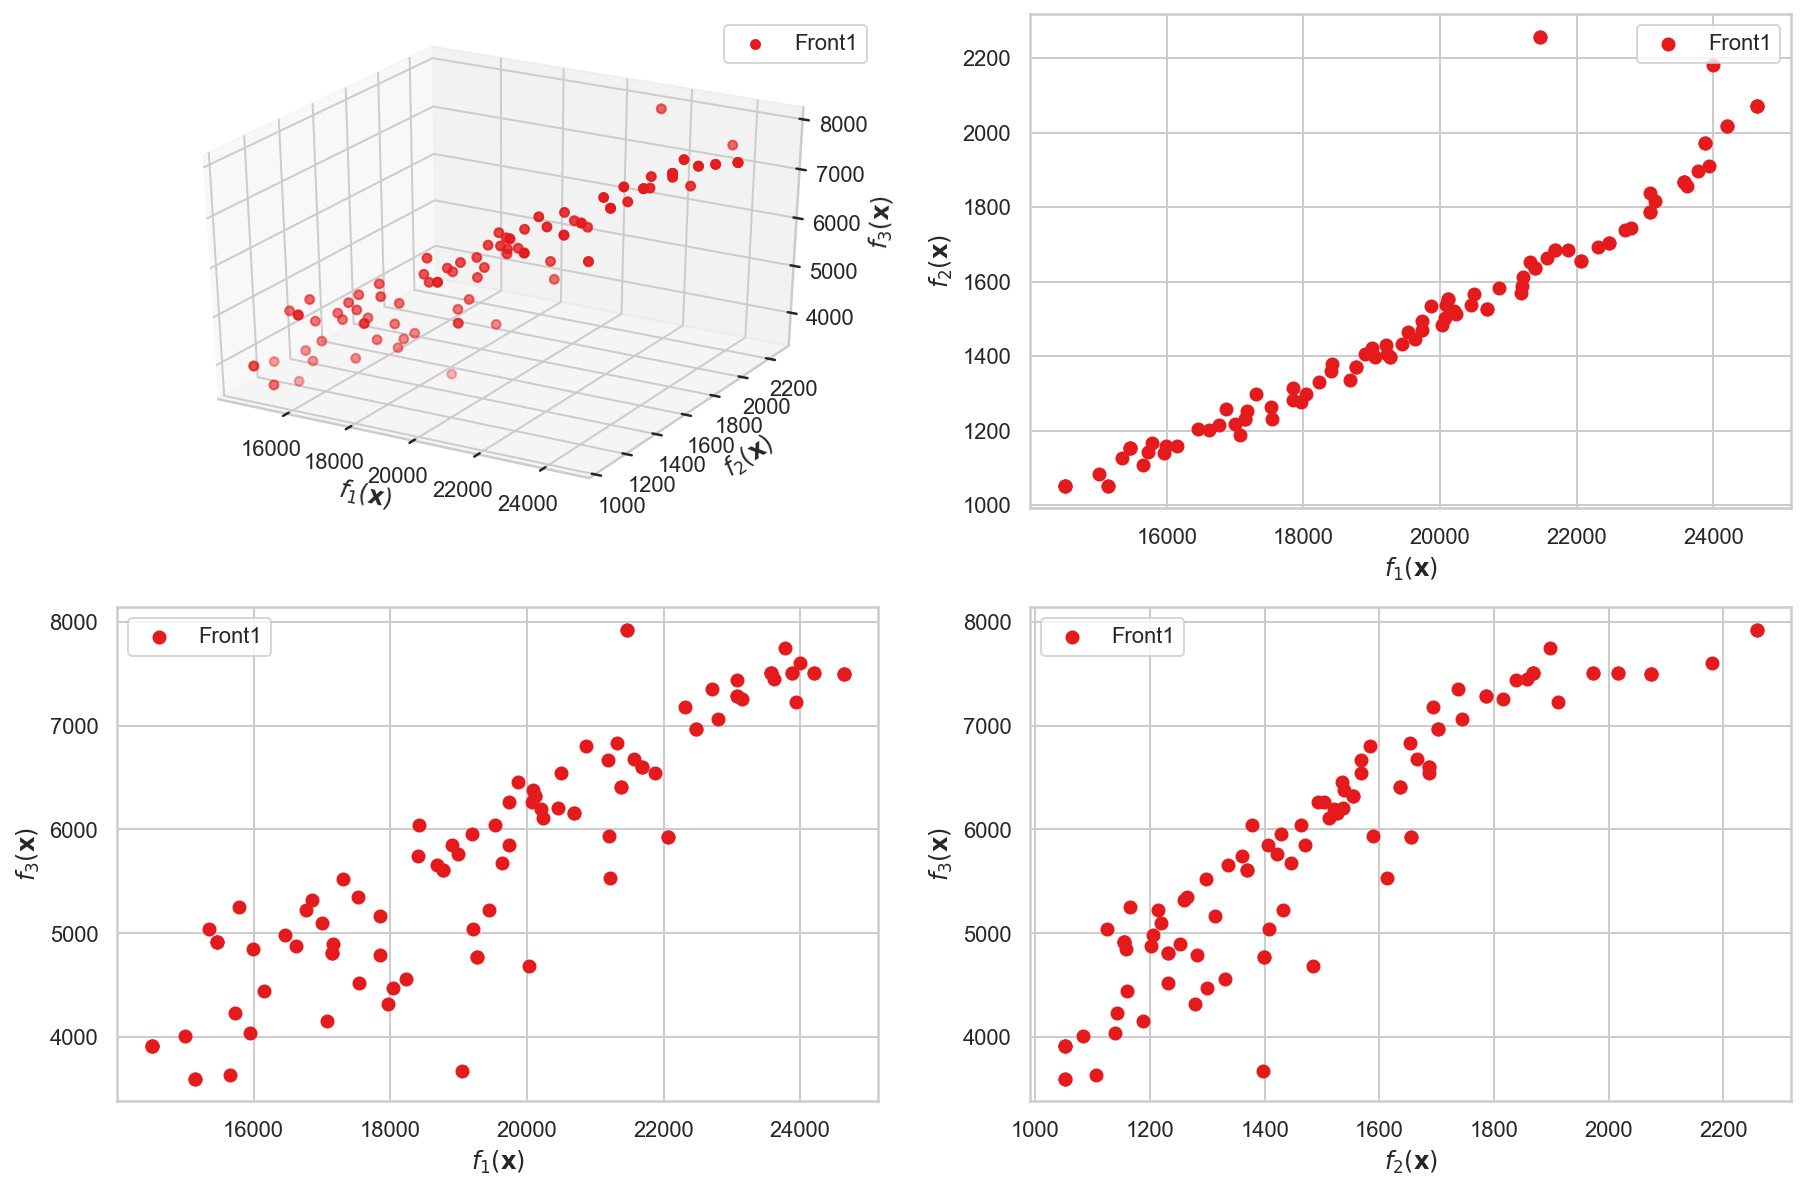

In [22]:
#file_name, m, pop_size, num_gen, mut_rate, xover_rate
instance = instance_create('jeu_100_25_1.txt', 3, 100, 100, .05, .8)
%time res, logbook, fronts, stats = execute_EA(instance)

### Generating Instances

In [31]:
### TODO: create function to generate all the instances we need for testing


In [21]:
stats

,front,instance_name,max_f1,max_f2,max_f3,mean_f1,mean_f2,mean_f3,median_f1,median_f2,...,min_f3,mut_rate,n_kp,num_gen,pop_size,sample_size,variance_f1,variance_f2,variance_f3,xover_rate
0,1,r_100_25_1,22135.164382,2128,7036,18641.351535,1690.76,5144.04,19264.0,1677.5,...,3365,0.05,3,50,50,50,7.351872e+06,46653.8624,910789.9984,0.8
